In [1]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

# 你要研究的barcode
test_cell = pd.read_csv('./addgene_add_crc_hic_eqtl_df_mat_RIS_index.txt', header=None)

In [2]:
test_cell = test_cell[0].values

In [ ]:
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

dataset_graph = ATACGraphDataset('./input_graph/')
seq_vec = torch.load('./seq.pth')


In [517]:



data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 


train_graph = []
test_graph = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):
    
    seq_data = seq_vec
    sample.seq_data = seq_data
    sample.id_vec = torch_vector
  
    # 请注意，如果你要添加边
    # 可以直接修改 sample.edge_index
    # sample.edge_index[1]是promoter节点的索引
    # sample.edge_index[0]是promoter节点对应的peak节点的索引
    # 每个索引代表的peak或promoter节点的含义可以通过dataset.array_peak查询
    # 比如
    # dataset_atac.array_peak
    # array(['ACAP3', 'VWA1', 'PRDM16', ..., 'chrX-154762391-154763458',
    # 
    # sample.edge_index
    # tensor([[21068, 21083, 21084,  ..., 56014, 56041, 56043],
    #     [    0,     1,     1,  ...,  1528,  1529,  1529]], device='cuda:3')
    # 0就代表了dataset_atac.array_peak[0]: 'ACAP3'
    # 21068就代表了dataset_atac.array_peak[21068] : 'chr1-1307926-1308733'
    # 
    # 假设我们要添加基因'ACAP3'和'chr1-1307926-1308733'，可以：
    # sample.edge_index[0] = torch.cat((sample.edge_index[0], torch.tensor([21068])))
    # sample.edge_index[1] = torch.cat((sample.edge_index[1], torch.tensor([0])))
    # 你当然也可以直接删除边，scReGAT采用的架构可以无视图的点边结构


    # 当然我们也可以在这里直接修改细胞的target基因表达y_exp
    # sample.y_exp = torch.tensor([新的值array])就可以了
    # 意味着我们可以轻松改成单细胞表达

    if sample.cell in test_cell:
        test_graph.append(sample)
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y)



# 下面是模型，这是KL散度版本
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=2,
                 node_output_dim=8,
                 edge_embedding_dim=1,
                 hidden_channels=8,
                 gat_input_channels=8,
                 gat_hidden_channels=8,
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.2,
                 num_head_1=8,
                 num_head_2=8):
        super(SCReGAT, self).__init__()
        torch.manual_seed(12345)

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),  # BatchNorm added after Linear
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),  # BatchNorm added
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(2, 12),
            nn.LayerNorm(12),  # BatchNorm added
            nn.LeakyReLU(),
            nn.Linear(12, edge_embedding_dim)
        )

        # GAT layers with dropout
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        # Adapters and dropout layers
        self.NN_adapter_barcode = nn.Linear(hidden_channels, 1)
        self.NN_adapter_bulk = nn.Linear(hidden_channels, 1, bias=True)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()


    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num, tag):
        data = raw_x
        seq_data = self.NN_seq(seq_data)
        data = torch.cat((data, seq_data), dim=1)
        data = self.NN_node(data)
        
        hidden_edge_input = torch.cat((raw_x[edge_index[0]], raw_x[edge_index[1]]), dim=1)
        hidden_edge = self.NN_edge(hidden_edge_input).sigmoid()
        self.edge = hidden_edge
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))

        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        
        data = data_1 + data_2
        
        # data = self.NN_adapter_bulk(data)
        self.data = data
        gene_out = -F.log_softmax(data, dim=1)[:, 0]
        return gene_out, atten_w1


# 你懂的

# 测试

# cell_link_mt 这个矩阵是[n_cell * n_edge]
# 其中边的与sample.edge_index的索引完全一致
# cell_type是你用于测试用的细胞类别

Processing samples: 100%|██████████| 7204/7204 [00:00<00:00, 8325.76it/s]


In [478]:
train_cell_type = [t.item() for t in train_cell_type]

In [479]:
from collections import Counter
import random

# Assuming `train_graph` is a list of graph objects and `train_cell_type` is a list of class labels corresponding to each graph
# Example (replace with your actual data):

# Step 1: Count the number of samples in each class
class_counts = Counter(train_cell_type)

# Step 2: Determine the maximum count of samples across all classes
max_count = max(class_counts.values())

# Step 3: Balance the dataset by duplicating samples from underrepresented classes
balanced_train_graph = []
balanced_train_cell_type = []

# Iterate through each class and duplicate samples if needed
for class_type in class_counts.keys():
    # Get all samples of the current class
    class_indices = [i for i, ct in enumerate(train_cell_type) if ct == class_type]
    class_samples = [train_graph[i] for i in class_indices]

    # Determine how many more samples are needed to balance
    num_to_add = max_count - class_counts[class_type]

    # Add the existing samples to the balanced lists
    balanced_train_graph.extend(class_samples)
    balanced_train_cell_type.extend([class_type] * len(class_samples))

    # If additional samples are needed, randomly duplicate existing samples from this class
    if num_to_add > 0:
        additional_samples = random.choices(class_samples, k=num_to_add)
        balanced_train_graph.extend(additional_samples)
        balanced_train_cell_type.extend([class_type] * num_to_add)

# Now, `balanced_train_graph` and `balanced_train_cell_type` contain a balanced dataset
print(f"Original class distribution: {class_counts}")
print(f"Balanced class distribution: {Counter(balanced_train_cell_type)}")


Original class distribution: Counter({5: 1968, 6: 1163, 3: 501, 0: 469, 4: 145, 1: 45, 2: 31})
Balanced class distribution: Counter({0: 1968, 1: 1968, 3: 1968, 6: 1968, 2: 1968, 5: 1968, 4: 1968})


In [481]:
balanced_train_graph

13776

In [482]:
import torch
import random
from tqdm import tqdm

def drop_edges(edge_index, drop_rate=0.1):
    """
    Randomly drop edges based on the specified drop rate.
    Args:
        edge_index (torch.Tensor): Tensor of shape (2, num_edges) representing the edges.
        drop_rate (float): The proportion of edges to drop.
    Returns:
        torch.Tensor: Modified edge_index after dropping edges.
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate  # Keep edges with probability 1 - drop_rate
    return edge_index[:, mask]

# 训练部分

# 假设你已经定义了 model, train_graph 等
model = SCReGAT()

gene_num = len(sample.y_exp)
device = 'cuda:0'
model.to(device)

# 使用 KL 散度损失
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 5
drop_edge_rate = 0.1

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0  
    train_loader = DataLoader(balanced_train_graph, batch_size=1, shuffle=True)
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")  
    count = 0

    for sample in progress_bar:
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()  

        # Apply edge dropout
        edge_index_dropped = drop_edges(sample.edge_index, drop_rate=drop_edge_rate)

        gene_pre, atten = model(
            sample.seq_data.to(device),
            sample.x.to(device), 
            edge_index_dropped.to(device),  # Use the modified edge_index
            sample.edge_tf.T.to(device), 
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device)
        )

        # 我们只考虑那些活性 > 0的promoter对应的基因表达，因为这样可以避免将0纳入
        index = torch.where(sample.x[:gene_num] >= 0)[0]
        gene_pre_log_prob = torch.log_softmax(gene_pre[index].flatten(), dim=-1)  

        loss = -loss_exp(gene_pre[index].flatten(), sample.y_exp[index].to(device)) 
       
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))  # 更新进度条的损失值
       
    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}")


TypeError: 'DataLoader' object is not subscriptable

In [337]:
gene_pre

tensor([1.4305e-06, 1.1921e-06, 1.0490e-05,  ..., 1.8853e+00, 1.8853e+00,
        1.8853e+00], device='cuda:0', grad_fn=<NegBackward0>)

In [6]:
gene_pre

tensor([0.0042, 0.0045, 0.0033,  ..., 1.9534, 1.9534, 1.9534], device='cuda:3',
       grad_fn=<NegBackward0>)

In [333]:
model = SCReGAT()
train_loader = DataLoader(train_graph, batch_size=1, shuffle=True)
gene_num = len(sample.y_exp)


# 训练部分

# 假设你已经定义了 model, train_graph 等
device = 'cuda:1'
model.to(device)

# 使用 KL 散度损失
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 5
drop_edge_rate = 0.1

for epoch in range(num_epoch):
    model.train()  
    random.shuffle(train_graph)
    train_loader = DataLoader(train_graph[:500], batch_size=1, shuffle=True)

    running_loss = 0.0  
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")  
    count = 0

    for sample in progress_bar:
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()  

        
        gene_pre, atten = model(
            sample.seq_data.to(device),
            sample.x.to(device), 
            sample.edge_index.to(device),
            sample.edge_tf.T.to(device), 
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device)
        )

        # 我们只考虑那些活性 > 0的promoter对应的基因表达，因为这样可以避免将0纳入
        # index = torch.where(sample.x[:gene_num] > 0)[0]
        # gene_pre_log_prob = torch.log_softmax(gene_pre[index].flatten(), dim=-1)  
        gene_pre_log_prob = torch.log_softmax(gene_pre[index].flatten(), dim=-1)  
        loss = -loss_exp(gene_pre[index].flatten(), sample.y_exp[index].to(device)) 
       
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))  # 更新进度条的损失值
       
    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}")



Epoch 1/5:   0%|          | 0/500 [00:00<?, ?batch/s]


RuntimeError: The size of tensor a (1194) must match the size of tensor b (109339) at non-singleton dimension 0

In [561]:
import torch
import random
from tqdm import tqdm

def drop_edges(edge_index, drop_rate=0.1):
    """
    Randomly drop edges based on the specified drop rate.
    Args:
        edge_index (torch.Tensor): Tensor of shape (2, num_edges) representing the edges.
        drop_rate (float): The proportion of edges to drop.
    Returns:
        torch.Tensor: Modified edge_index after dropping edges.
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate  # Keep edges with probability 1 - drop_rate
    return edge_index[:, mask]

# 训练部分

# 假设你已经定义了 model, train_graph 等
model = SCReGAT()
train_loader = DataLoader(train_graph, batch_size=1, shuffle=True)
gene_num = len(sample.y_exp)
device = 'cuda:2'
model.to(device)

# 使用 KL 散度损失
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 5
drop_edge_rate = 0.1

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    random.shuffle(balanced_train_graph)
    train_loader = DataLoader(balanced_train_graph[:500], batch_size=1, shuffle=True)
  
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")  
    count = 0
    
    for sample in progress_bar:
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()  

        # Apply edge dropout
        edge_index_dropped = drop_edges(sample.edge_index, drop_rate=drop_edge_rate)

        gene_pre, atten = model(
            sample.seq_data.to(device),
            sample.x.to(device), 
            edge_index_dropped.to(device),  # Use the modified edge_index
            sample.edge_tf.T.to(device), 
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device)
        )

        # 我们只考虑那些活性 > 0的promoter对应的基因表达，因为这样可以避免将0纳入
        
        index = torch.where(sample.x[:gene_num] > 0)[0]
        gene_pre_log_prob = torch.log_softmax(gene_pre[index].flatten(), dim=-1)  
        loss = -loss_exp(gene_pre[index].flatten(), sample.y_exp[index].to(device))  + torch.mean(model.edge)
       
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))  # 更新进度条的损失值
       
    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/5: 100%|██████████| 500/500 [01:13<00:00,  6.81batch/s, loss=0.172]


Epoch [1/5], Average Loss: 0.1715


Epoch 2/5:   1%|          | 5/500 [00:00<01:20,  6.13batch/s, loss=0.0226]


KeyboardInterrupt: 

In [562]:
model.edge[index_interset]


tensor([[0.0107],
        [0.0110],
        [0.0253],
        ...,
        [0.0116],
        [0.0116],
        [0.0116]], device='cuda:2', grad_fn=<IndexBackward0>)

In [484]:
gene_pre.shape

torch.Size([109339])

In [485]:
edge_count_dict

{0: 255,
 1: 96,
 2: 83,
 3: 176,
 4: 63,
 5: 103,
 6: 190,
 7: 221,
 8: 109,
 9: 159,
 10: 189,
 11: 129,
 12: 103,
 13: 91,
 14: 78,
 15: 68,
 16: 81,
 17: 58,
 18: 72,
 19: 63,
 20: 133,
 21: 147,
 22: 93,
 23: 134,
 24: 130,
 25: 124,
 26: 70,
 27: 106,
 28: 77,
 29: 65,
 30: 72,
 31: 104,
 32: 40,
 33: 123,
 34: 56,
 35: 218,
 36: 67,
 37: 65,
 38: 66,
 39: 152,
 40: 216,
 41: 54,
 42: 89,
 43: 43,
 44: 144,
 45: 54,
 46: 39,
 47: 115,
 48: 115,
 49: 44,
 50: 109,
 51: 108,
 52: 110,
 53: 176,
 54: 72,
 55: 218,
 56: 128,
 57: 154,
 58: 123,
 59: 135,
 60: 139,
 61: 62,
 62: 61,
 63: 75,
 64: 120,
 65: 169,
 66: 103,
 67: 114,
 68: 79,
 69: 106,
 70: 22,
 71: 81,
 72: 55,
 73: 174,
 74: 126,
 75: 156,
 76: 164,
 77: 173,
 78: 58,
 79: 94,
 80: 33,
 81: 64,
 82: 226,
 83: 113,
 84: 69,
 85: 67,
 86: 58,
 87: 62,
 88: 40,
 89: 117,
 90: 145,
 91: 145,
 92: 75,
 93: 133,
 94: 166,
 95: 105,
 96: 129,
 97: 101,
 98: 96,
 99: 104,
 100: 115,
 101: 57,
 102: 26,
 103: 130,
 104: 137,
 1

In [486]:
edge_count_dict = dict()

for t in torch.unique(atten[0][1]):
    edge_count_dict[t.item()] = len(atten[0][0][atten[0][1] == t])
edge_count_list = [] 

for t in atten[0][1]:
    edge_count_list.append(edge_count_dict[t.item()])
edge_count_list = torch.tensor(edge_count_list)

Processing Batches:   0%|          | 1/2882 [00:00<04:55,  9.73it/s]

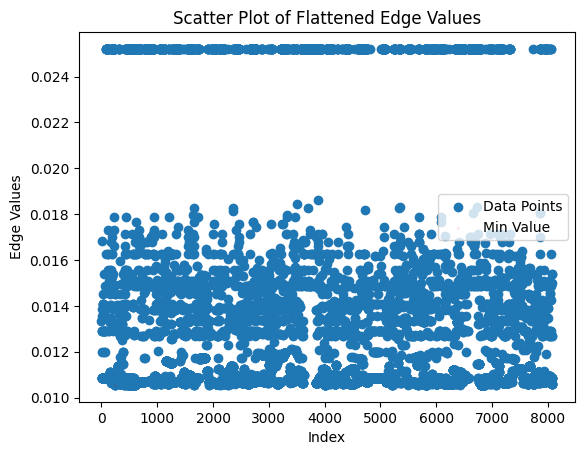

Processing Batches:   0%|          | 7/2882 [00:02<10:32,  4.54it/s]

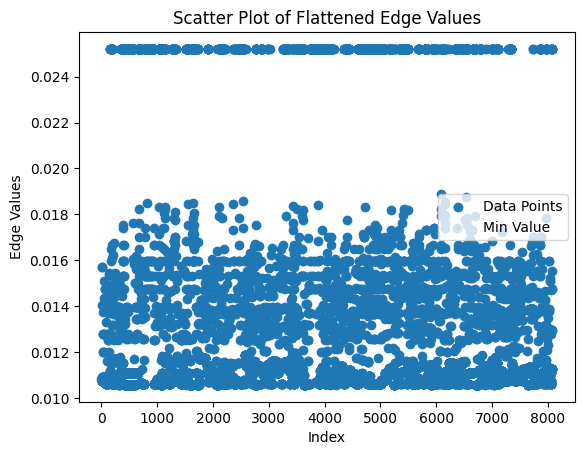

Processing Batches:   0%|          | 13/2882 [00:03<09:07,  5.24it/s]

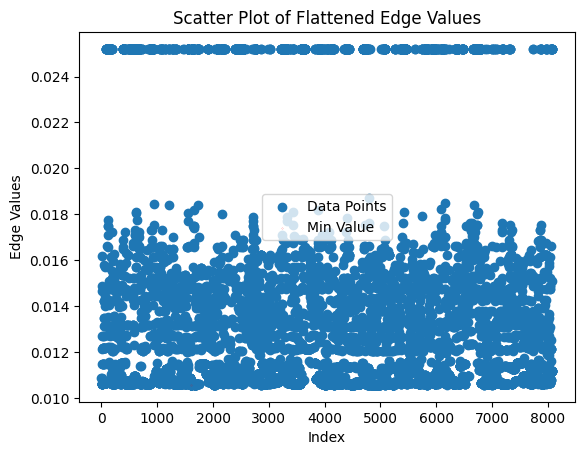

Processing Batches:   1%|          | 17/2882 [00:05<11:22,  4.20it/s]

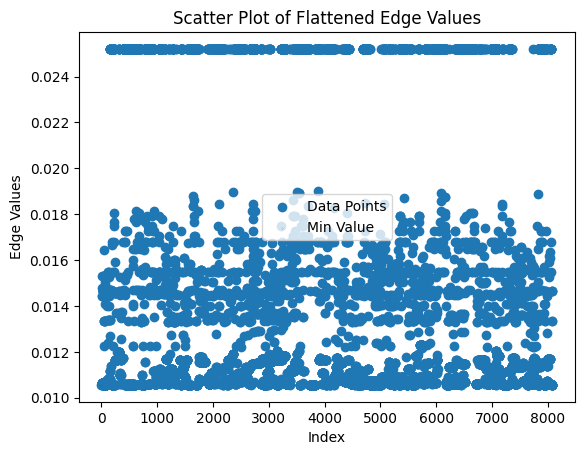

Processing Batches:   1%|          | 18/2882 [00:06<17:59,  2.65it/s]

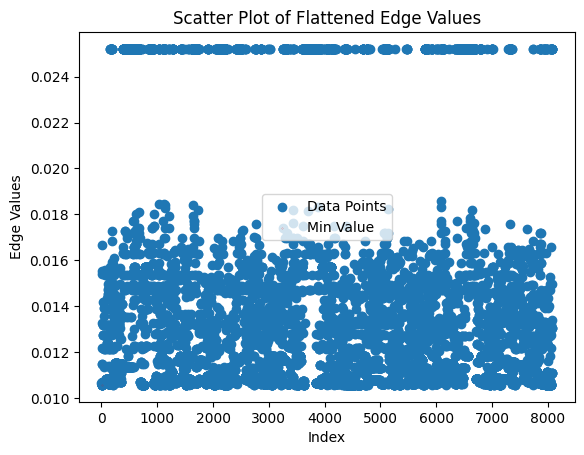

Processing Batches:   1%|          | 24/2882 [00:07<10:59,  4.34it/s]

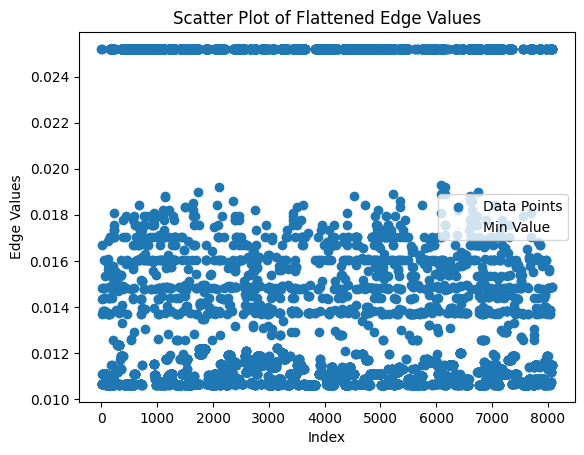

Processing Batches:   1%|          | 36/2882 [00:09<05:16,  8.99it/s]

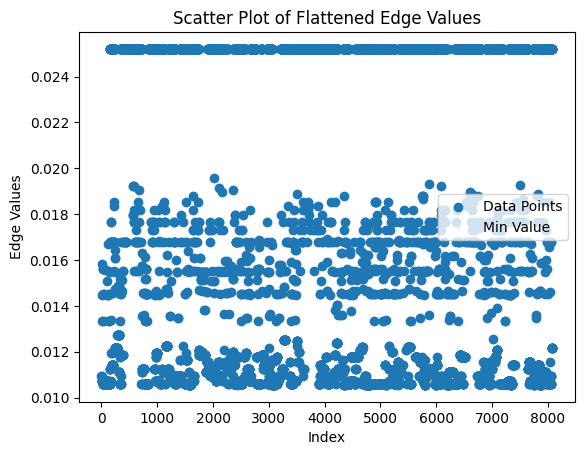

Processing Batches:   2%|▏         | 48/2882 [00:10<04:35, 10.28it/s]

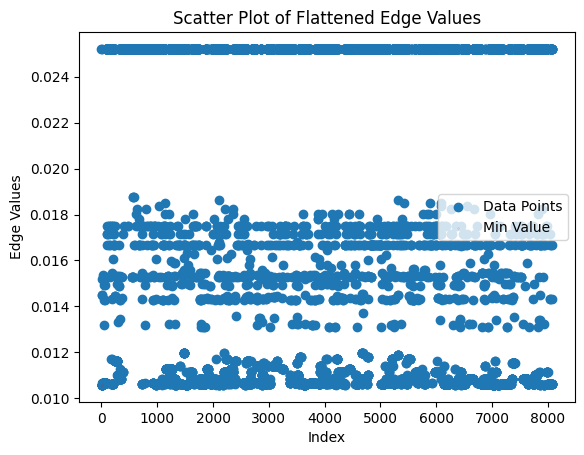

Processing Batches:   2%|▏         | 60/2882 [00:12<04:49,  9.76it/s]

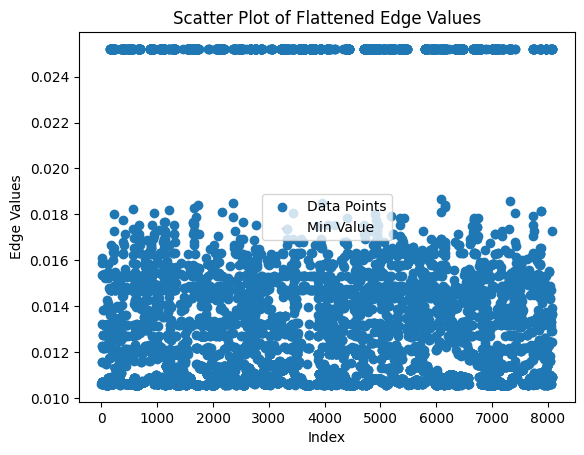

Processing Batches:   2%|▏         | 66/2882 [00:13<06:59,  6.71it/s]

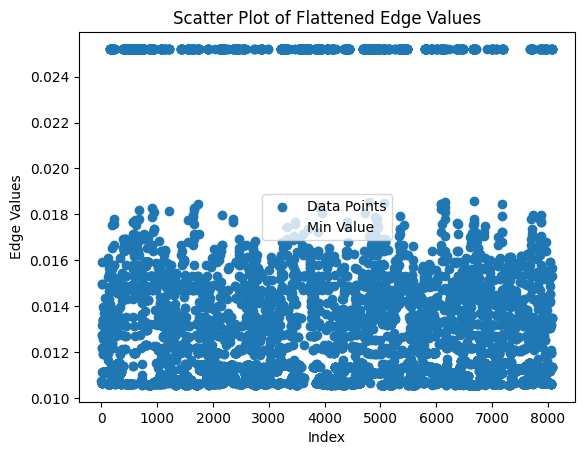

Processing Batches:   2%|▏         | 68/2882 [00:15<12:30,  3.75it/s]

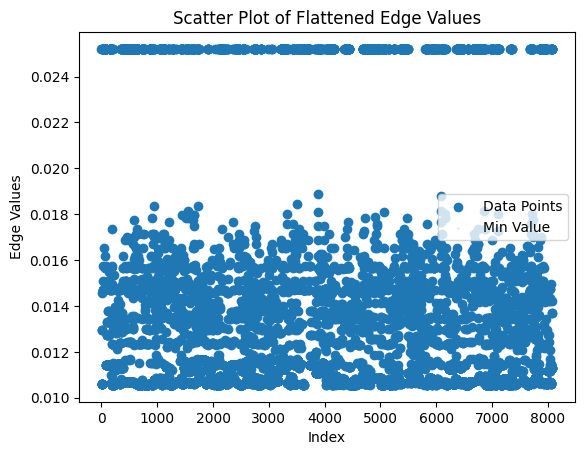

Processing Batches:   2%|▏         | 71/2882 [00:16<13:22,  3.50it/s]

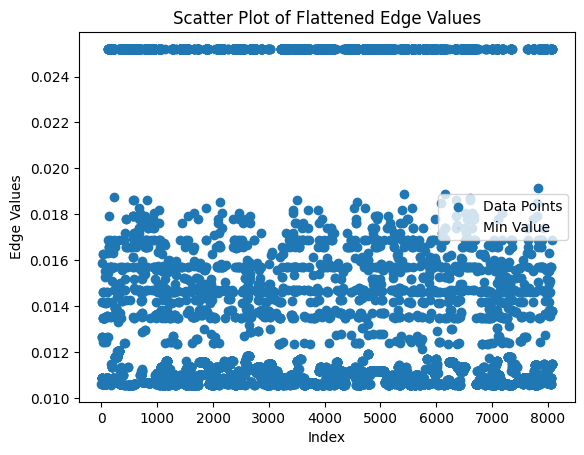

Processing Batches:   3%|▎         | 73/2882 [00:17<16:56,  2.76it/s]

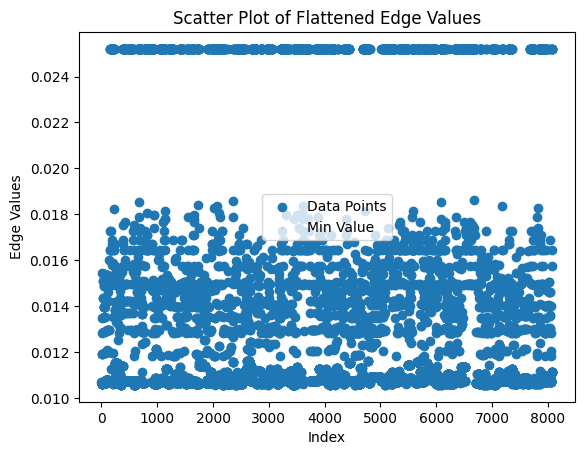

Processing Batches:   3%|▎         | 78/2882 [00:18<11:36,  4.03it/s]

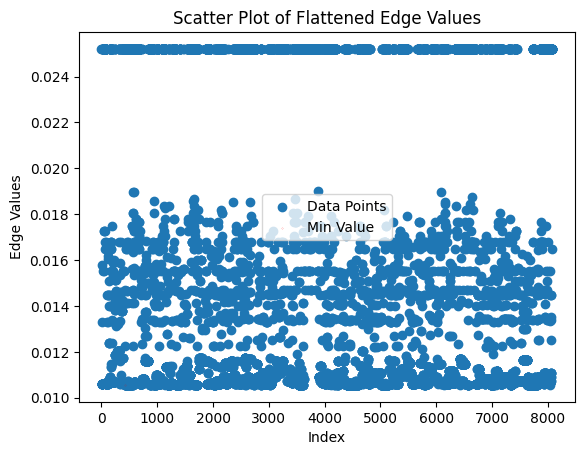

Processing Batches:   3%|▎         | 82/2882 [00:19<11:11,  4.17it/s]


KeyboardInterrupt: 

In [572]:
test_loader = DataLoader(test_graph, batch_size=1, shuffle=True, pin_memory=True)
model.eval()  # 切换到评估模式
test_loss = 0.0  # 初始化测试集的总损失

# 使用 torch.no_grad() 禁用梯度计算
device = 'cpu'
model.to(device)
model.eval()
cell_type = []

with torch.no_grad():
    cell_link_mt = []
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        if sample.y != 6:
            continue
        gene_pre, atten = model(sample.seq_data.to(device),
                                sample.x.to(device), 
                                sample.edge_index.to(device), 
                                sample.edge_tf.T.to(device), 
                                sample.batch.to(device), gene_num, sample.id_vec.to(device))
        cell_type.append(sample.y.item())
        
        
        atten1_max = torch.mean(atten[1], dim=1)
        flattened_sample_x = sample.to(device).x[atten[0][1].cpu()].flatten()
        
        temp = atten1_max  * flattened_sample_x
        cell_link_mt.append(temp)

            
            # Assuming model.edge.flatten() returns a NumPy array or PyTorch tens  import matplotlib.pyplot as plt

            # Assuming model.edge.flatten() returns a NumPy array or PyTorch tensor
        edges = model.edge.flatten().cpu().numpy()  # Convert to NumPy if it's a PyTorch tensor


        # Assuming model.edge.flatten() returns a NumPy array or PyTorch tensor
        edges = model.edge.flatten().cpu().numpy()[index_interset]  # Convert to NumPy if it's a PyTorch tensor
        indices = np.arange(len(edges))
        min_index = np.argmin(edges)

        plt.scatter(indices, edges, label='Data Points')
        plt.scatter(min_index, edges[min_index], s=0.01, color='red', label='Min Value')  # Highlight the min value
        plt.xlabel('Index')
        plt.ylabel('Edge Values')
        plt.title('Scatter Plot of Flattened Edge Values')
        plt.legend()
        plt.show()



In [571]:
t0 = torch.where(model.edge.flatten() > 0.0240)[0]

In [583]:
len(t0)

29889

In [584]:
len(t6)

47349

In [585]:
t6 = torch.where(model.edge.flatten() > 0.0240)[0]

In [586]:
len(np.intersect1d(t0.numpy(), t6))

16910

In [580]:
t6

tensor([     0,      1,      2,  ..., 143273, 143274, 143275])

In [ ]:
sample.g

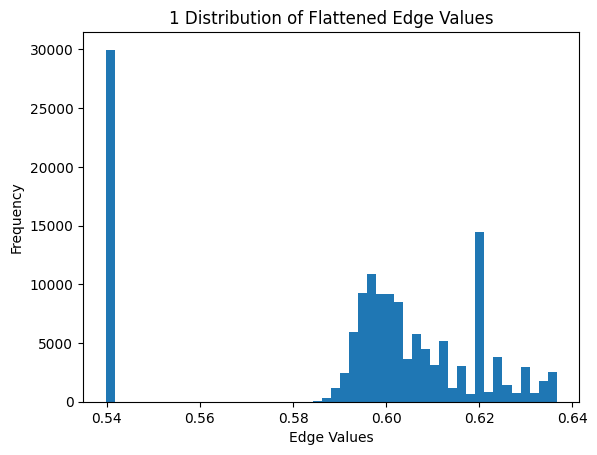

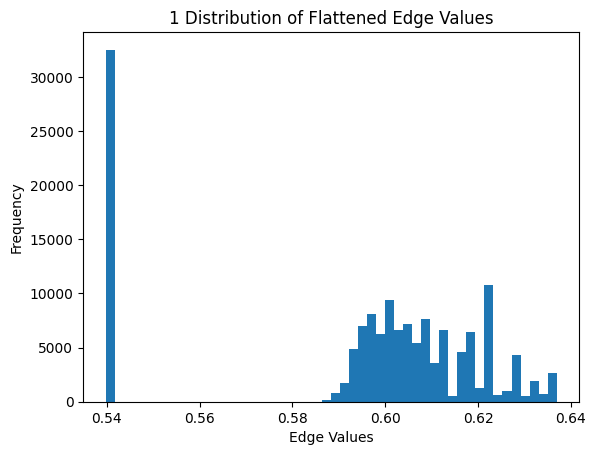

In [540]:
import matplotlib.pyplot as plt

# Assuming model.edge.flatten() returns a NumPy array or PyTorch tensor
edges = model.edge.flatten().cpu().numpy()  # Convert to NumPy if it's a PyTorch tensor

plt.hist(edges, bins=50)
plt.xlabel('Edge Values')
plt.ylabel('Frequency')
plt.title('1 Distribution of Flattened Edge Values')
plt.show()


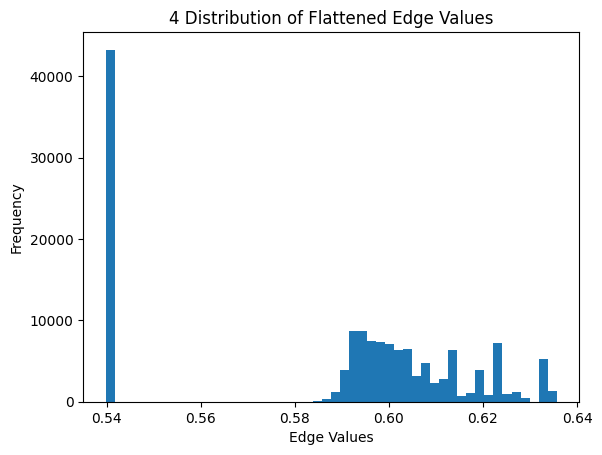

In [530]:
import matplotlib.pyplot as plt

# Assuming model.edge.flatten() returns a NumPy array or PyTorch tensor
edges = model.edge.flatten().cpu().numpy()  # Convert to NumPy if it's a PyTorch tensor

plt.hist(edges, bins=50)
plt.xlabel('Edge Values')
plt.ylabel('Frequency')
plt.title('4 Distribution of Flattened Edge Values')
plt.show()


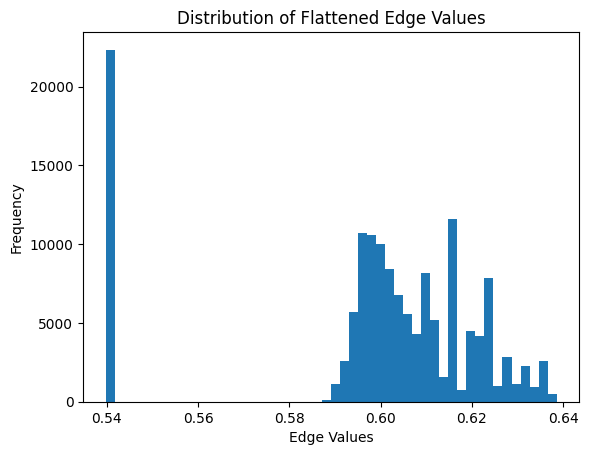

In [527]:
# 6
import matplotlib.pyplot as plt

# Assuming model.edge.flatten() returns a NumPy array or PyTorch tensor
edges = model.edge.flatten().cpu().numpy()  # Convert to NumPy if it's a PyTorch tensor

plt.hist(edges, bins=50)
plt.xlabel('Edge Values')
plt.ylabel('Frequency')
plt.title('Distribution of Flattened Edge Values')
plt.show()


In [516]:
model.edge

tensor([[0.6067, 0.3310, 0.4418,  ..., 0.4754, 0.5587, 0.5665],
        [0.6067, 0.3310, 0.4418,  ..., 0.4754, 0.5587, 0.5665],
        [0.6576, 0.4097, 0.5045,  ..., 0.5744, 0.3786, 0.4951],
        ...,
        [0.6465, 0.4220, 0.4874,  ..., 0.5877, 0.3785, 0.5142],
        [0.6453, 0.4223, 0.4873,  ..., 0.5888, 0.3775, 0.5124],
        [0.6670, 0.4275, 0.4981,  ..., 0.5799, 0.4116, 0.4990]],
       device='cuda:1')

In [501]:
sample.y 

tensor([0], device='cuda:1')

In [430]:
temp_df = pd.read_csv('./overlap.csv', index_col=0)['0'].values

In [432]:
from tqdm import tqdm

index_interset = []
for t in tqdm(temp_df, desc="Processing items"):
    try:
        index_interset.append(list(cell_link_df.columns).index(t))
    except:
        continue

print(index_interset)


Processing items: 100%|██████████| 8099/8099 [01:47<00:00, 75.50it/s]

[29379, 29380, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29732, 29733, 29734, 29735, 29736, 29737, 29738, 29739, 29740, 18335, 18336, 18337, 18338, 29847, 29849, 29850, 29852, 29852, 29853, 29853, 29854, 29856, 29858, 29859, 29860, 29861, 29862, 29863, 29865, 29867, 29869, 29871, 29873, 29877, 29879, 29880, 29882, 29884, 29887, 29889, 29891, 29893, 29893, 29895, 29897, 29899, 29899, 29901, 29902, 29904, 29906, 29908, 29910, 29912, 29914, 29916, 29918, 29924, 29926, 29928, 29930, 29938, 29939, 29940, 29941, 29943, 29945, 29947, 29949, 29951, 29953, 29956, 29957, 29958, 29959, 29960, 30153, 17406, 30159, 30160, 30161, 30178, 30178, 30179, 30180, 30181, 30182, 30182, 30183, 30184, 30185, 30185, 30186, 30187, 30188, 30189, 30189, 30190, 30191, 30192, 30195, 30196, 30197, 30198, 30199, 30200, 30201, 30202, 30203, 30204, 30233, 30234, 30235, 30237, 30238, 30238, 30239, 30245, 30262, 30263, 30265, 30275, 30276, 30277, 41, 42, 43, 43, 30279, 30280, 30281, 30282, 30283, 30284, 30285, 302

In [427]:
cell_link_df.columns[0]

"('MXRA8','chr1-1359679-1360179')"

In [431]:
temp_df[0]

"('CASZ1','chr1-10579413-10579913')"

In [433]:
index_interset

[29379,
 29380,
 29725,
 29726,
 29727,
 29728,
 29729,
 29730,
 29731,
 29732,
 29733,
 29734,
 29735,
 29736,
 29737,
 29738,
 29739,
 29740,
 18335,
 18336,
 18337,
 18338,
 29847,
 29849,
 29850,
 29852,
 29852,
 29853,
 29853,
 29854,
 29856,
 29858,
 29859,
 29860,
 29861,
 29862,
 29863,
 29865,
 29867,
 29869,
 29871,
 29873,
 29877,
 29879,
 29880,
 29882,
 29884,
 29887,
 29889,
 29891,
 29893,
 29893,
 29895,
 29897,
 29899,
 29899,
 29901,
 29902,
 29904,
 29906,
 29908,
 29910,
 29912,
 29914,
 29916,
 29918,
 29924,
 29926,
 29928,
 29930,
 29938,
 29939,
 29940,
 29941,
 29943,
 29945,
 29947,
 29949,
 29951,
 29953,
 29956,
 29957,
 29958,
 29959,
 29960,
 30153,
 17406,
 30159,
 30160,
 30161,
 30178,
 30178,
 30179,
 30180,
 30181,
 30182,
 30182,
 30183,
 30184,
 30185,
 30185,
 30186,
 30187,
 30188,
 30189,
 30189,
 30190,
 30191,
 30192,
 30195,
 30196,
 30197,
 30198,
 30199,
 30200,
 30201,
 30202,
 30203,
 30204,
 30233,
 30234,
 30235,
 30237,
 30238,
 30238,


In [434]:
index_interset = torch.tensor(index_interset)

In [444]:
mt = cell_link_df.iloc[:, np.array(index_interset)]

In [439]:
from tqdm import tqdm

# 初始化空列表
results = {i: [] for i in range(7)}

for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
    for i in range(7):
        if sample.y == i:
            results[i].append(torch.median(sample.to(device).x[atten[0][1].cpu()].flatten()[index_interset]).item())

print(results)


Processing Batches:  30%|███       | 867/2882 [00:57<02:14, 15.01it/s]


KeyboardInterrupt: 

In [440]:
np.mean(results[0]), np.mean(results[1]), np.mean(results[2]), np.mean(results[3]), np.mean(results[4]), np.mean(results[5]), np.mean(results[6])

(1.7127080047549914,
 1.7978460639715195,
 1.6784131526947021,
 1.7354281102457354,
 1.759105309844017,
 1.3480727036667477,
 1.410116180726343)

In [460]:
from tqdm import tqdm
test_loader = DataLoader(test_graph, batch_size=1, shuffle=False, pin_memory=True)
cell_type = []
for i in tqdm(test_loader):
    cell_type.append(i.y.item())


100%|██████████| 2882/2882 [01:42<00:00, 28.00it/s]


In [458]:
i.y

tensor([3])

In [388]:
df

,Group,Values
0,B,0.997448
1,B,0.997448
2,B,0.997923
3,B,0.997839
4,B,0.997924
...,...,...
56688,T_Epithelial,0.999458
56689,T_Epithelial,0.999078
56690,T_Epithelial,0.999179
56691,T_Epithelial,0.999465


In [387]:
dataset_atac.array_celltype

array(['B', 'Fibroblast', 'Myeloid', 'N_Epithelial', 'P_Epithelial', 'T',
       'T_Epithelial'], dtype=object)

In [375]:
np.mean(results[0]), np.mean(results[1]), np.mean(results[2]), np.mean(results[3]), np.mean(results[4]), np.mean(results[5]), np.mean(results[6])

(1.5200418048347069,
 1.5978289475807776,
 1.5094663131804693,
 1.5264228202402592,
 1.528395633425629,
 1.3981413910309768,
 1.4270281045827815)

In [382]:
index_valid

tensor([ 46550,  46550, 115536,  ...,  85005,  85006,  85007])

In [ ]:
dataset_atac.

In [376]:
dataset_atac.array_celltype

array(['B', 'Fibroblast', 'Myeloid', 'N_Epithelial', 'P_Epithelial', 'T',
       'T_Epithelial'], dtype=object)

In [414]:
temp_df

,x
1,"('A2M','chr12-8709390-8709890')"
2,"('A2M','chr12-8709390-8709890')"
3,"('ABCA1','chr9-107918652-107919152')"
4,"('ABCA1','chr9-107929677-107930177')"
5,"('ABCA1','chr9-107999805-108000305')"
...,...
8095,"('ZNRF3','chr22-29457733-29458233')"
8096,"('ZNRF3','chr22-29458239-29458739')"
8097,"('ZNRF3','chr22-29458791-29459291')"
8098,"('ZNRF3','chr22-29459418-29459918')"


In [386]:
sample.y, sample.cell

(tensor([6], device='cuda:0'), ['OMIX005759-18#P25_C_D_21_309'])

tensor([0.0000, 0.0000, 1.1905,  ..., 2.5212, 2.5212, 2.5212], device='cuda:0')

In [355]:
len(cell_type)

1165

In [356]:
cell_link_mt = torch.vstack(cell_link_mt)

In [357]:
cell_link_mt.shape

torch.Size([1164, 143276])

In [351]:
dataset_atac.array_celltype


array(['B', 'Fibroblast', 'Myeloid', 'N_Epithelial', 'P_Epithelial', 'T',
       'T_Epithelial'], dtype=object)

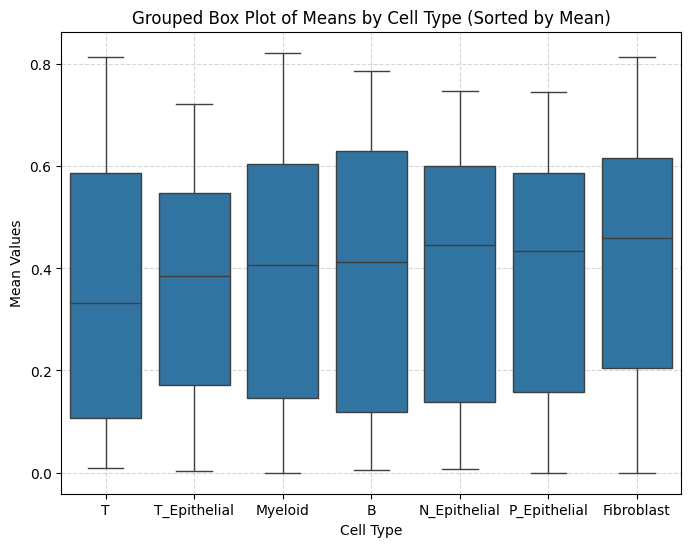

In [463]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming `temp_normalized` and `cell_type_cpu` are defined as in your description
import numpy as np

# Assuming mt.values is a NumPy array
temp_normalized = (mt.values - np.min(mt.values, axis=0)) / (np.max(mt.values, axis=0) - np.min(mt.values, axis=0))

cell_type_cpu = torch.tensor(cell_type)
# Calculate means for each cell type group
mean_0 = np.mean(temp_normalized[cell_type_cpu == 0, :], axis=0)
mean_1 = np.mean(temp_normalized[cell_type_cpu == 1, :], axis=0)
mean_2 = np.mean(temp_normalized[cell_type_cpu == 2, :], axis=0)
mean_3 = np.mean(temp_normalized[cell_type_cpu == 3, :], axis=0)
mean_4 = np.mean(temp_normalized[cell_type_cpu == 4, :], axis=0)
mean_5 = np.mean(temp_normalized[cell_type_cpu == 5, :], axis=0)
mean_6 = np.mean(temp_normalized[cell_type_cpu == 6, :], axis=0)

# Combine the means into a DataFrame for plotting
data = {
    'Group': ['B'] * len(mean_0) + ['Fibroblast'] * len(mean_1) +
             ['Myeloid'] * len(mean_2) + ['N_Epithelial'] * len(mean_3) +
             ['P_Epithelial'] * len(mean_4) + ['T'] * len(mean_5) + ['T_Epithelial'] * len(mean_6),
    'Values': np.concatenate([mean_0, mean_1, mean_2, mean_3, mean_4, mean_5, mean_6])
}

df = pd.DataFrame(data)

# Calculate the overall mean of each group for sorting purposes
group_means = df.groupby('Group')['Values'].mean().sort_values()

# Reorder the groups based on the calculated means
sorted_groups = group_means.index.tolist()
df['Group'] = pd.Categorical(df['Group'], categories=sorted_groups, ordered=True)

# Create the box plot with sorted groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Values', data=df)
plt.title("Grouped Box Plot of Means by Cell Type (Sorted by Mean)")
plt.ylabel("Mean Values")
plt.xlabel("Cell Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [447]:
temp_normalized[cell_type_cpu == 0, :]

InvalidIndexError: (False, slice(None, None, None))

In [296]:
t1[0], t2[0]

('chr1-1359679-1360179', 'MXRA8')

In [303]:
t1[0]

'chr1-1359679-1360179'

In [316]:
str_list = []
for i in range(len(t1)):
    str_list.append(t1[i] + ':' + t2[i])

In [317]:
tt1 = df.values[:, 0]
tt2 = df.values[:, 1]

In [318]:
str_list2 = []
for i in range(len(tt1)):
    str_list2.append(tt2[i] + ':' + tt1[i])

In [322]:
indices = [np.where(str_list == item)[0] for item in str_list2 if item in str_list]


In [328]:
from tqdm import tqdm

index_valid = []
for i in tqdm(str_list2, desc="Processing items"):
    index_valid.append(list(str_list).index(i))

print(index_valid)


Processing items: 100%|██████████| 8099/8099 [00:27<00:00, 298.00it/s]

[46550, 46550, 115536, 115538, 115541, 115554, 115555, 115556, 115557, 115558, 115559, 115560, 115562, 63400, 63401, 63402, 63435, 63496, 63496, 63497, 63498, 63499, 63500, 63501, 63502, 63503, 63504, 63505, 63506, 63507, 63508, 63509, 63510, 63510, 63511, 63515, 63517, 63519, 63519, 63522, 63524, 63526, 63528, 63529, 63531, 63533, 63535, 63537, 63539, 63541, 63543, 63547, 63551, 63559, 63561, 63562, 63564, 63571, 63575, 63579, 63584, 63591, 63593, 63596, 63599, 63602, 63603, 63604, 63605, 63606, 63612, 63619, 63622, 56457, 56458, 67153, 67154, 60660, 60662, 60664, 4744, 4745, 60746, 60746, 60747, 60748, 4718, 4719, 4720, 4721, 4805, 60859, 44216, 44225, 44226, 63572, 63576, 63580, 63585, 74656, 74657, 74658, 74659, 74661, 74662, 74664, 74682, 74684, 74685, 74686, 74687, 2458, 2459, 2459, 2460, 2461, 98069, 98070, 98070, 98071, 98083, 98084, 98086, 98087, 98087, 98088, 98093, 98094, 98095, 114293, 71737, 71738, 106613, 106614, 106615, 106616, 106617, 106618, 106651, 106869, 106876, 510

In [329]:
str_list[46550]

'chr12-8709390-8709890:A2M'

In [299]:
index_valid = []
for i in df.values:
    t1[i]
    print(pos_dict[i[0]])

257
257
1150
1150
1150
1150
1150
1150
1150
1150
1150
1150
1150
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
504
397
397
542
542
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
226
226
226
503
503
503
503
646
646
646
646
646
646
646
646
646
646
646
646
646
646
646
646
646
937
937
937
937
937
937
937
937
937
937
937
937
937
1136
605
605
1040
1040
1040
1040
1040
1040
1040
1040
1040
1076
1076
1076
1076
1076
1076
1076
206
206
206
206
206
1014
122
122
122
830
830
830
830
305
1101
1101
1101
1101
1101
1101
334
621
621
621
621
621
621
621
621
621
621
621
621
621
621
621
621
621
621
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
622
930
930
930
930
930
930
930
930
930
930
930
930
930
930
930
930
930
930
9

array([['A2M', 'chr12-8709390-8709890'],
       ['A2M', 'chr12-8709390-8709890'],
       ['ABCA1', 'chr9-107918652-107919152'],
       ...,
       ['ZNRF3', 'chr22-29458791-29459291'],
       ['ZNRF3', 'chr22-29459418-29459918'],
       ['ZNRF3', 'chr22-29470261-29470761']], dtype=object)

In [285]:
torch.tensor(matching_indices)

tensor([    41,     42,     43,  ..., 117344, 117347, 117348])

In [289]:
atten[0][0][41]

tensor(2748, device='cuda:1')

In [288]:
dataset_atac.array_peak[11]

'CAMK2N1'

In [290]:
dataset_atac.array_peak[2748]

'chr1-20486083-20486583'

In [252]:
dataset_atac.array_peak[1]

'KCNAB2'

In [255]:
pos_dict['A2M']

257

In [258]:
temp_df = pd.read_csv('./intersect_CRC_cellline_link.txt')

# Define a function to clean up the gene and chromosome location
def clean_location(entry):
    # Remove any unwanted characters
    return entry.strip("')")

# Clean the index and data
temp_df['Gene'] = temp_df.index.str.strip("('")
temp_df['Location'] = temp_df['x'].apply(clean_location)

# Drop the original 'x' column
temp_df = temp_df.drop(columns=['x'])

# Display the cleaned DataFrame
print(temp_df)


                         Gene                     Location
1 "('A2M'            1 "('A2M     chr12-8709390-8709890')"
2 "('A2M'            2 "('A2M     chr12-8709390-8709890')"
3 "('ABCA1'        3 "('ABCA1  chr9-107918652-107919152')"
4 "('ABCA1'        4 "('ABCA1  chr9-107929677-107930177')"
5 "('ABCA1'        5 "('ABCA1  chr9-107999805-108000305')"
...                       ...                          ...
8095 "('ZNRF3'  8095 "('ZNRF3   chr22-29457733-29458233')"
8096 "('ZNRF3'  8096 "('ZNRF3   chr22-29458239-29458739')"
8097 "('ZNRF3'  8097 "('ZNRF3   chr22-29458791-29459291')"
8098 "('ZNRF3'  8098 "('ZNRF3   chr22-29459418-29459918')"
8099 "('ZNRF3'  8099 "('ZNRF3   chr22-29470261-29470761')"

[8099 rows x 2 columns]


In [263]:
gene_list = [t.split('\'')[-1] for t in temp_df['Gene'].values]

In [267]:
peak_list = [t.split('\'')[0] for t in temp_df['Location'].values]

In [292]:
df = pd.DataFrame({'gene':gene_list, 'peak':peak_list})

In [269]:
cpc_index_1 = []
cpc_index_2 = []
for i in range(len(gene_list)):
    cpc_index_1.append(pos_dict[peak_list[i]])
    cpc_index_2.append(pos_dict[gene_list[i]])


In [273]:
cpc_index = torch.tensor([cpc_index_1, cpc_index_2])

In [278]:
atten_0 = atten[0]
cpc_index_list = list(zip(cpc_index[0].tolist(), cpc_index[1].tolist()))

atten_0_list = list(zip(atten_0[0].tolist(), atten_0[1].tolist()))

# Find indices where `cpc_index` pairs appear in `atten[0]`
matching_indices = [i for i, pair in enumerate(atten_0_list) if pair in cpc_index_list]


In [280]:
len(matching_indices)

7650

In [223]:
# Calculate the min and max for each column
# cell_link_mt = torch.vstack(cell_link_mt)
min_vals = torch.min(cell_link_mt, dim=0).values
max_vals = torch.max(cell_link_mt, dim=0).values

# Calculate the range (max - min) and handle division by zero
range_vals = max_vals - min_vals
range_vals[range_vals == 0] = 1  # Avoid division by zero

# Normalize each column to be between 0 and 1
normalized_min_max = (cell_link_mt - min_vals) / range_vals


In [ ]:
overlap_index = torch.tensor(overlap_indices)

In [211]:
cell_link_mt = torch.vstack(cell_link_mt)

In [281]:
cell_link_mt[:, matching_indices]

tensor([[0.0120, 0.0115, 0.0115,  ..., 0.0430, 0.0430, 0.0438],
        [0.0079, 0.0076, 0.0076,  ..., 0.0432, 0.0420, 0.0420],
        [0.0060, 0.0058, 0.0058,  ..., 0.0431, 0.0438, 0.0431],
        ...,
        [0.0211, 0.0204, 0.0204,  ..., 0.0519, 0.0519, 0.0519],
        [0.0000, 0.0000, 0.0000,  ..., 0.0517, 0.0518, 0.0518],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [330]:
index_valid = torch.tensor(index_valid)

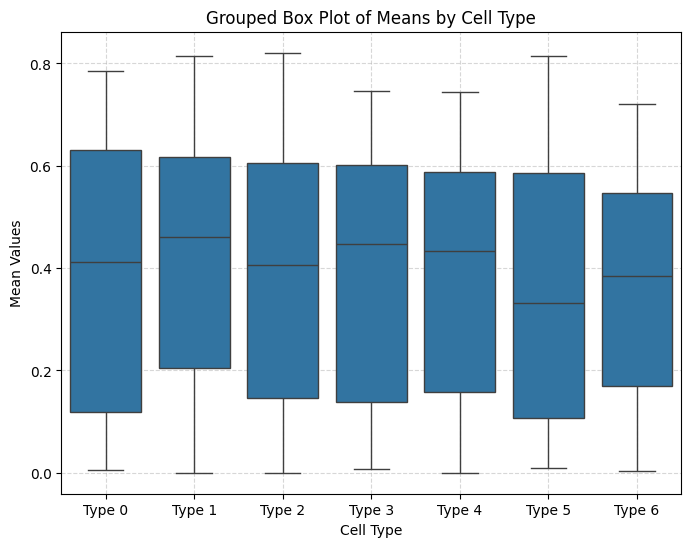

In [332]:
temp_normalized = normalized_min_max[:, index_valid].cpu().numpy()

# Convert `cell_type` to a numpy array if it's not already
cell_type_cpu = np.array(cell_type)

# Calculate means for each cell type group
mean_0 = np.mean(temp_normalized[cell_type_cpu == 0, :], axis=0)
mean_1 = np.mean(temp_normalized[cell_type_cpu == 1, :], axis=0)
mean_2 = np.mean(temp_normalized[cell_type_cpu == 2, :], axis=0)
mean_3 = np.mean(temp_normalized[cell_type_cpu == 3, :], axis=0)
mean_4 = np.mean(temp_normalized[cell_type_cpu == 4, :], axis=0)
mean_5 = np.mean(temp_normalized[cell_type_cpu == 5, :], axis=0)
mean_6 = np.mean(temp_normalized[cell_type_cpu == 6, :], axis=0)

# Combine the means into a DataFrame for plotting
data = {
    'Group': ['Type 0'] * len(mean_0) + ['Type 1'] * len(mean_1) +
             ['Type 2'] * len(mean_2) + ['Type 3'] * len(mean_3) +
             ['Type 4'] * len(mean_4) + ['Type 5'] * len(mean_5) + ['Type 6'] * len(mean_6),
    'Values': np.concatenate([mean_0, mean_1, mean_2, mean_3, mean_4, mean_5, mean_6])
}

df = pd.DataFrame(data)

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Values', data=df)
plt.title("Grouped Box Plot of Means by Cell Type")
plt.ylabel("Mean Values")
plt.xlabel("Cell Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [226]:
dataset_atac.array_celltype

array(['B', 'Fibroblast', 'Myeloid', 'N_Epithelial', 'P_Epithelial', 'T',
       'T_Epithelial'], dtype=object)

In [225]:
cell_type

[0,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 5,
 3,
 5,
 0,
 6,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 3,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 3,
 5,
 1,
 0,
 5,
 0,
 0,
 0,
 1,
 5,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
3 4 

In [168]:
cpc_df = pd.read_csv('./CPC_loop.csv', index_col=0)

In [169]:
df_temp = pd.DataFrame({'region':t1, 'gene':t2})

In [170]:
linked_values = cpc_df[['Chromosome1', 'Start1', 'End1']].apply(lambda x: f"{x[0]}-{x[1]}-{x[2]}", axis=1)

In [171]:
cpc_df

,Chromosome1,Start1,End1,Chromosome2,Start2,End2,Matched_Region,Matched_Gene
246,chr1,10579413,10579913,chr1,10574841,10580991,chr1:10574841-10580991,CASZ1
247,chr1,10579950,10580450,chr1,10574841,10580991,chr1:10574841-10580991,CASZ1
481,chr1,16496353,16496853,chr1,16495270,16503480,chr1:16495270-16503480,EPHA2
482,chr1,16497179,16497679,chr1,16495270,16503480,chr1:16495270-16503480,EPHA2
483,chr1,16498320,16498820,chr1,16495270,16503480,chr1:16495270-16503480,EPHA2
...,...,...,...,...,...,...,...,...
48242,chrX,154028707,154029207,chrX,154027386,154034563,chrX:154027386-154034563,DKC1
48246,chrX,154029272,154029772,chrX,154027386,154034563,chrX:154027386-154034563,DKC1
48247,chrX,154056611,154057111,chrX,154053103,154056923,chrX:154053103-154056923,DKC1
48250,chrX,154056611,154057111,chrX,154056937,154057802,chrX:154056937-154057802,DKC1


In [174]:
index_pair = []
for i in range(len(linked_values)):
    index_pair.append([pos_dict[linked_values.values[i]], pos_dict[cpc_df['Matched_Gene'].values[i]]])

In [178]:
pair_index = atten[0].cpu()

In [180]:
pair_index_list = list(zip(pair_index[0].tolist(), pair_index[1].tolist()))

# Convert `index_pair` to a set of tuples for faster lookup
index_pair_set = set(map(tuple, index_pair))

# Find the overlap using set intersection
overlap_pairs = [pair for pair in pair_index_list if pair in index_pair_set]

# Display the result
print("Overlapping pairs:", overlap_pairs)

Overlapping pairs: [(2748, 11), (2749, 11), (2750, 11), (6909, 64), (6910, 64), (7346, 71), (7347, 71), (7348, 71), (7843, 77), (7844, 77), (7845, 77), (7846, 77), (7847, 77), (7848, 77), (56483, 134), (56484, 134), (56485, 134), (61888, 198), (61889, 198), (61890, 198), (61959, 200), (61960, 200), (61961, 200), (66472, 250), (66473, 250), (66474, 250), (66475, 250), (66476, 250), (67614, 262), (67615, 262), (67616, 262), (67617, 262), (67618, 262), (67619, 262), (70172, 296), (70173, 296), (70174, 296), (70175, 296), (72187, 318), (72188, 318), (72189, 318), (72190, 318), (72191, 318), (72192, 318), (77605, 377), (77606, 377), (80102, 404), (80103, 404), (82707, 436), (82708, 436), (82709, 436), (82710, 436), (95298, 569), (95299, 569), (95300, 569), (95301, 569), (12795, 615), (12796, 615), (12797, 615), (15764, 646), (15765, 646), (15766, 646), (15767, 646), (106128, 765), (19616, 787), (36014, 968), (36015, 968), (36016, 968), (36017, 968), (40814, 1023), (40815, 1023), (40817, 102

In [184]:
pair_index_list = list(zip(pair_index[0].tolist(), pair_index[1].tolist()))

# Convert `index_pair` to a set of tuples for faster lookup
index_pair_set = set(map(tuple, index_pair))

# Find the indices of overlaps
overlap_indices = [i for i, pair in enumerate(pair_index_list) if pair in index_pair_set]

# Display the result
print("Indices of overlapping pairs in pair_index:", overlap_indices)

Indices of overlapping pairs in pair_index: [41, 42, 43, 231, 232, 251, 252, 253, 276, 277, 278, 279, 280, 281, 495, 496, 497, 740, 741, 742, 747, 748, 749, 951, 952, 953, 954, 955, 1002, 1003, 1004, 1005, 1006, 1007, 1133, 1134, 1135, 1136, 1220, 1221, 1222, 1223, 1224, 1225, 1445, 1446, 1531, 1532, 1634, 1635, 1636, 1637, 2152, 2153, 2154, 2155, 2344, 2345, 2346, 2458, 2459, 2460, 2461, 2925, 3015, 3688, 3689, 3690, 3691, 3903, 3904, 3906, 4196, 4197, 4198, 4199, 4200, 4205, 4206, 4718, 4719, 4720, 4721, 4744, 4745, 4805, 5104, 5118, 5397, 5434, 5453, 5454, 5455, 5456, 5457, 5458, 5529, 5546, 5547, 5548, 5549, 5550, 5982, 5983, 5984, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 6309, 6310, 6311, 6981, 6982, 6983, 6984, 6985, 7151, 7192, 7193, 7455, 7457, 7458, 7459, 7467, 7468, 7550, 7705, 7706, 7707, 7718, 7719, 7720, 7724, 7728, 7729, 7730, 7805, 7898, 7965, 8005, 8121, 8122, 8126, 8127, 8177, 8324, 8325, 8326, 8327, 8328, 8329, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8534, 85

In [186]:
atten[0][1][41]

tensor(11, device='cuda:0')

In [187]:
atten[0][0][41]

tensor(2748, device='cuda:0')

In [192]:
pd.DataFrame(overlap_indices).to_csv('CPC_index.csv', index=False)

In [159]:
linked_values

0

In [161]:
pos_dict = dict()

for t in range(len(dataset_atac.array_peak)):
    pos_dict[dataset_atac.array_peak[t]] = t

0              chr1-915722-916222
1              chr1-915722-916222
2              chr1-915722-916222
3              chr1-915722-916222
4              chr1-915722-916222
                   ...           
48262    chrX-154452713-154453213
48263    chrX-154457461-154457961
48264    chrX-154457983-154458483
48265    chrX-154459018-154459518
48266    chrX-154459828-154460328
Length: 48267, dtype: object

In [154]:
cpc_df

,Chromosome1,Start1,End1,Chromosome2,Start2,End2,Matched_Region,Matched_Gene
0,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,PUSL1
1,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,SAMD11
2,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,MIR200B
3,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,SDF4
4,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,UBE2J2
...,...,...,...,...,...,...,...,...
48262,chrX,154452713,154453213,chrX,154449948,154454812,chrX:154449948-154454812,TMLHE
48263,chrX,154457461,154457961,chrX,154456722,154462044,chrX:154456722-154462044,TMLHE
48264,chrX,154457983,154458483,chrX,154456722,154462044,chrX:154456722-154462044,TMLHE
48265,chrX,154459018,154459518,chrX,154456722,154462044,chrX:154456722-154462044,TMLHE


In [ ]:
matching_indices

In [149]:
df_temp

,region,gene,region_formatted
0,chr1-1359679-1360179,MXRA8,chr1:1359679:1360179
1,chr1-1360476-1360976,MXRA8,chr1:1360476:1360976
2,chr1-5991535-5992035,KCNAB2,chr1:5991535:5992035
3,chr1-5992247-5992747,KCNAB2,chr1:5992247:5992747
4,chr1-5992856-5993356,KCNAB2,chr1:5992856:5993356
...,...,...,...
143271,chrX-154465444-154465944,DKC1,chrX:154465444:154465944
143272,chrX-154486499-154486999,FLNA,chrX:154486499:154486999
143273,chrX-154489479-154489979,DKC1,chrX:154489479:154489979
143274,chrX-154819830-154820330,DKC1,chrX:154819830:154820330


In [141]:
cpc_df.head()

,Chromosome1,Start1,End1,Chromosome2,Start2,End2,Matched_Region,Matched_Gene
0,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,PUSL1
1,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,SAMD11
2,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,MIR200B
3,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,SDF4
4,chr1,915722,916222,chr1,903641,927394,chr1:903641-927394,UBE2J2


In [124]:
atten1_max , edge_count_list

(tensor([0.0039, 0.0039, 0.0107,  ..., 0.0157, 0.0160, 0.0157], device='cuda:0'),
 tensor([255, 255,  96,  ...,  63,  63,  63]))

In [83]:
sample.to(device).x[atten[0][1].cpu()].flatten()

tensor([0.0000, 0.0000, 2.1480,  ..., 2.7443, 2.7443, 2.7443], device='cuda:0')

In [19]:
cell_type_code = []
for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
    cell_type_code.append(sample.cell[0])

Processing Batches: 100%|██████████| 2882/2882 [04:07<00:00, 11.63it/s]


In [23]:
mt = pd.DataFrame(cell_link_mt)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2823c86bb0>>
Traceback (most recent call last):
  File "/root/anaconda3/envs/HT2VEC/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2823c86bb0>>
Traceback (most recent call last):
  File "/root/anaconda3/envs/HT2VEC/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2823c86bb0>>
Traceback (most recent call last):
  File "/root/anaconda3/envs/HT2VEC/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775,

In [127]:
cell_link_mt = torch.vstack(cell_link_mt)


In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 缩放到 0-1 范围
df_normalized = pd.DataFrame(scaler.fit_transform(df_weight_in), columns=df_weight_in.columns)

print(df_normalized)


      ('MXRA8','chr1-1359679-1360179')  ('MXRA8','chr1-1360476-1360976')  \
0                                  0.0                               0.0   
1                                  0.0                               0.0   
2                                  0.0                               0.0   
3                                  0.0                               0.0   
4                                  0.0                               0.0   
...                                ...                               ...   
2877                               0.0                               0.0   
2878                               0.0                               0.0   
2879                               0.0                               0.0   
2880                               0.0                               0.0   
2881                               0.0                               0.0   

      ('KCNAB2','chr1-5991535-5992035')  ('KCNAB2','chr1-5992247-5992747')  \
0        

In [30]:
import torch
import pandas as pd

# 假设 cell_link_mt 是你的 PyTorch 矩阵
# cell_link_mt = torch.randn(10, 5)  # 示例矩阵

# 转换为 NumPy 数组
cell_link_np = cell_link_mt.numpy()

# 转换为 Pandas 数据框
cell_link_df = pd.DataFrame(cell_link_np)

print(cell_link_df)


      0       1         2         3         4         5         6       \
0        0.0     0.0  0.023003  0.023030  0.022865  0.014790  0.014657   
1        0.0     0.0  0.015840  0.015944  0.015920  0.018281  0.018370   
2        0.0     0.0  0.024761  0.024779  0.024542  0.000000  0.000000   
3        0.0     0.0  0.004992  0.005181  0.004885  0.000000  0.000000   
4        0.0     0.0  0.011222  0.011378  0.010840  0.005837  0.005712   
...      ...     ...       ...       ...       ...       ...       ...   
2877     0.0     0.0  0.018405  0.018473  0.017686  0.000000  0.000000   
2878     0.0     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2879     0.0     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2880     0.0     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2881     0.0     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

        7         8         9       ...    143266    143267    143268  143269  \
0     0.014269  0.000000  0.00

In [32]:
cell_link_df.index = cell_type_code

In [53]:
cell_link_df.columns = colnames

In [55]:
cell_link_df.to_csv('./ris_baselin_kl.csv', index=False)

In [36]:

temp_index = atten[0].to('cpu')

In [51]:
t1 = dataset_atac.array_peak[temp_index[0].numpy()]
t2 = dataset_atac.array_peak[temp_index[1].numpy()]

colnames = []
for i in range(len(t1)):
    colnames.append("(" + '\'' + t2[i] + '\'' + ',' + '\'' + t1[i] + '\'' + ")")

In [59]:
pd.DataFrame(cell_type_code).to_csv('cell_name.csv')

In [42]:
('MXRA8','chr1-1359549-1360049')

array(['MXRA8', 'MXRA8', 'KCNAB2', ..., 'DKC1', 'DKC1', 'DKC1'],
      dtype=object)

In [251]:
cell_type_code

['OMIX005759-28#P09_C_A_58_58',
 'OMIX005759-28#P09_C_C_74_266',
 'OMIX005759-28#P09_C_A_80_80',
 'OMIX005759-28#P09_C_B_90_186',
 'OMIX005759-28#P09_C_D_78_366',
 'OMIX005759-28#P09_C_D_73_361',
 'OMIX005759-28#P09_C_D_3_291',
 'OMIX005759-28#P09_T_B_69_165',
 'OMIX005759-28#P09_T_A1_52_52',
 'OMIX005759-28#P09_C_D_65_353',
 'OMIX005759-28#P09_C_D_18_306',
 'OMIX005759-28#P09_T_D_19_307',
 'OMIX005759-28#P09_T_A1_28_28',
 'OMIX005759-28#P09_T_C1_23_215',
 'OMIX005759-28#P09_C_A_66_66',
 'OMIX005759-28#P09_T_A1_69_69',
 'OMIX005759-28#P09_T_A1_78_78',
 'OMIX005759-28#P09_T_A_42_42',
 'OMIX005759-28#P09_T_B_53_149',
 'OMIX005759-28#P09_C_A_64_64',
 'OMIX005759-28#P09_C_C_94_286',
 'OMIX005759-28#P09_T_A_67_67',
 'OMIX005759-28#P09_C_C_79_271',
 'OMIX005759-28#P09_T_A1_57_57',
 'OMIX005759-28#P09_T_A1_3_3',
 'OMIX005759-28#P09_T_C_85_277',
 'OMIX005759-28#P09_T_C1_45_237',
 'OMIX005759-28#P09_C_C_37_229',
 'OMIX005759-28#P09_C_C_55_247',
 'OMIX005759-28#P09_T_A_22_22',
 'OMIX005759-28#P0

In [62]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# data = torch.tensor(cell_link_mt)
# Convert Torch tensor to numpy array if needed
data_np = cell_link_mt.numpy()

# PCA on data1_mt (numpy array)
pca1 = PCA(n_components=2)
pca_result1 = pca1.fit_transform(data_np)


select_cell_id_np = np.array(cell_type)

In [91]:
1

1

In [72]:
import pandas as pd
import numpy as np

df_normalized = df_weight_in.div(df_weight_in.sum(axis=0), axis=1)

print(df_normalized)


                              ('MXRA8','chr1-1359679-1360179')  \
OMIX005759-28#P09_C_A_58_58                                0.0   
OMIX005759-28#P09_C_C_74_266                               0.0   
OMIX005759-28#P09_C_A_80_80                                0.0   
OMIX005759-28#P09_C_B_90_186                               0.0   
OMIX005759-28#P09_C_D_78_366                               0.0   
...                                                        ...   
OMIX005759-18#P25_T_A_61_61                                0.0   
OMIX005759-18#P25_T_A_62_62                                0.0   
OMIX005759-18#P25_C_D_23_311                               0.0   
OMIX005759-18#P25_C_D_18_306                               0.0   
OMIX005759-18#P25_C_D_21_309                               0.0   

                              ('MXRA8','chr1-1360476-1360976')  \
OMIX005759-28#P09_C_A_58_58                                0.0   
OMIX005759-28#P09_C_C_74_266                               0.0   
OMIX00575

In [ ]:
df_weight_in = df_normalized

In [96]:
df_normalized

,"('MXRA8','chr1-1359679-1360179')","('MXRA8','chr1-1360476-1360976')","('KCNAB2','chr1-5991535-5992035')","('KCNAB2','chr1-5992247-5992747')","('KCNAB2','chr1-5992856-5993356')","('PIK3CD','chr1-9651489-9651989')","('PIK3CD','chr1-9652268-9652768')","('PIK3CD','chr1-9653136-9653636')","('CASZ1','chr1-10794319-10794819')","('CASZ1','chr1-10795289-10795789')",...,"('FLNA','chrX-154436419-154436919')","('FLNA','chrX-154443932-154444432')","('FLNA','chrX-154450064-154450564')","('SSR4','chrX-154452713-154453213')","('FLNA','chrX-154459828-154460328')","('DKC1','chrX-154465444-154465944')","('FLNA','chrX-154486499-154486999')","('DKC1','chrX-154489479-154489979')","('DKC1','chrX-154819830-154820330')","('DKC1','chrX-155057342-155057842')"
0,0.0,0.0,0.678336,0.679229,0.688372,0.326941,0.336246,0.327317,0.000000,0.000000,...,0.335556,0.325682,0.322290,0.0,0.322290,0.670483,0.325775,0.651471,0.687572,0.651271
1,0.0,0.0,0.467106,0.470237,0.479280,0.404132,0.421449,0.418397,0.000000,0.000000,...,0.474050,0.477081,0.474049,0.0,0.474049,0.654669,0.457595,0.654704,0.677106,0.635911
2,0.0,0.0,0.730176,0.730834,0.738870,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.524897,0.514701,0.520164,0.0,0.511737,0.671802,0.515048,0.652754,0.688547,0.670472
3,0.0,0.0,0.147214,0.152820,0.147054,0.000000,0.000000,0.000000,0.206379,0.206379,...,0.409775,0.395755,0.392835,0.0,0.403596,0.695635,0.396272,0.689443,0.695638,0.697233
4,0.0,0.0,0.330910,0.335574,0.326341,0.129039,0.131054,0.131053,0.497407,0.497406,...,0.413187,0.400822,0.397810,0.0,0.404508,0.683677,0.401379,0.684285,0.683679,0.687297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,0.0,0.0,0.542738,0.544834,0.532452,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396164,0.384319,0.380385,0.0,0.380385,0.742485,0.384312,0.721432,0.742487,0.744118
2878,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.564055,0.564055,...,0.000000,0.000000,0.000000,0.0,0.000000,0.649977,0.000000,0.631547,0.649978,0.653094
2879,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.810251,0.000000,0.816339,0.810250,0.816159
2880,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.807863,0.000000,0.813705,0.807862,0.784715


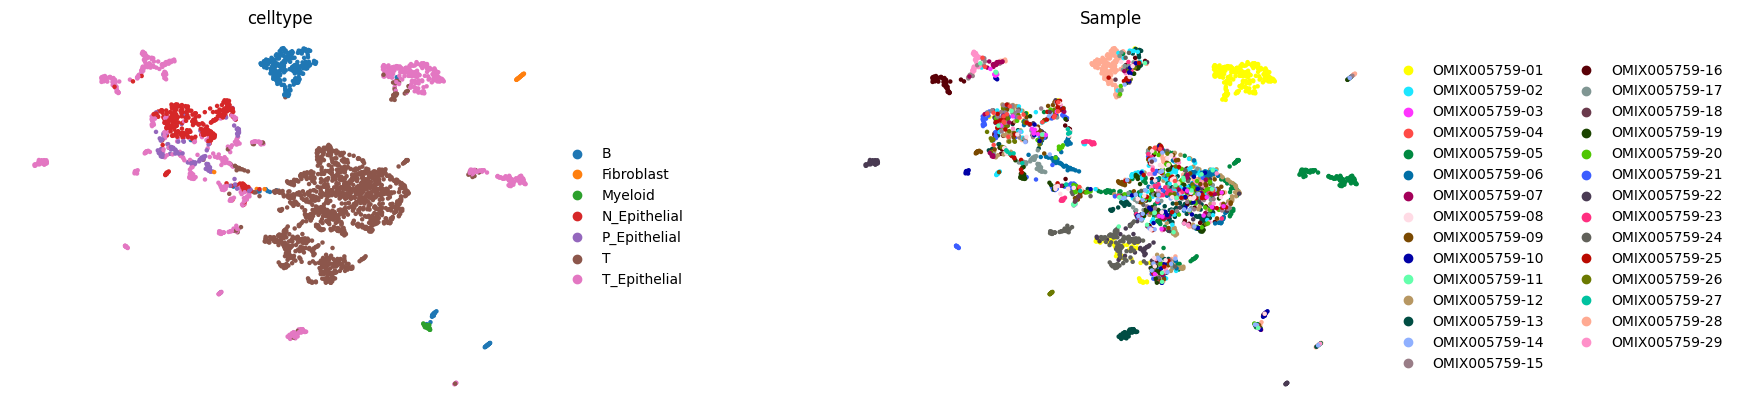

In [129]:
import numpy as np
df_weight_in = cell_link_df
adata_edge = ad.AnnData(
    X=cell_link_mt.cpu().numpy(), obs=dataset_atac.adata.obs.loc[df_weight_in.index, :])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype', 'Sample'], wspace=0.4,frameon=False)

In [67]:
cell_link_df

,"('MXRA8','chr1-1359679-1360179')","('MXRA8','chr1-1360476-1360976')","('KCNAB2','chr1-5991535-5992035')","('KCNAB2','chr1-5992247-5992747')","('KCNAB2','chr1-5992856-5993356')","('PIK3CD','chr1-9651489-9651989')","('PIK3CD','chr1-9652268-9652768')","('PIK3CD','chr1-9653136-9653636')","('CASZ1','chr1-10794319-10794819')","('CASZ1','chr1-10795289-10795789')",...,"('FLNA','chrX-154436419-154436919')","('FLNA','chrX-154443932-154444432')","('FLNA','chrX-154450064-154450564')","('SSR4','chrX-154452713-154453213')","('FLNA','chrX-154459828-154460328')","('DKC1','chrX-154465444-154465944')","('FLNA','chrX-154486499-154486999')","('DKC1','chrX-154489479-154489979')","('DKC1','chrX-154819830-154820330')","('DKC1','chrX-155057342-155057842')"
OMIX005759-28#P09_C_A_58_58,0.0,0.0,0.023003,0.023030,0.022865,0.014790,0.014657,0.014269,0.000000,0.000000,...,0.011208,0.011268,0.010766,0.0,0.010766,0.042911,0.011272,0.042911,0.044004,0.042911
OMIX005759-28#P09_C_C_74_266,0.0,0.0,0.015840,0.015944,0.015920,0.018281,0.018370,0.018240,0.000000,0.000000,...,0.015834,0.016507,0.015835,0.0,0.015835,0.041899,0.015833,0.043124,0.043335,0.041899
OMIX005759-28#P09_C_A_80_80,0.0,0.0,0.024761,0.024779,0.024542,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017532,0.017809,0.017376,0.0,0.017094,0.042995,0.017821,0.042996,0.044067,0.044176
OMIX005759-28#P09_C_B_90_186,0.0,0.0,0.004992,0.005181,0.004885,0.000000,0.000000,0.000000,0.004468,0.004468,...,0.013687,0.013693,0.013122,0.0,0.013482,0.044520,0.013711,0.045412,0.044521,0.045939
OMIX005759-28#P09_C_D_78_366,0.0,0.0,0.011222,0.011378,0.010840,0.005837,0.005712,0.005713,0.010769,0.010769,...,0.013801,0.013868,0.013289,0.0,0.013512,0.043755,0.013888,0.045073,0.043755,0.045285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OMIX005759-18#P25_T_A_61_61,0.0,0.0,0.018405,0.018473,0.017686,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013232,0.013297,0.012707,0.0,0.012706,0.047519,0.013297,0.047519,0.047519,0.049028
OMIX005759-18#P25_T_A_62_62,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012212,0.012212,...,0.000000,0.000000,0.000000,0.0,0.000000,0.041598,0.000000,0.041599,0.041598,0.043031
OMIX005759-18#P25_C_D_23_311,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.051856,0.000000,0.053771,0.051856,0.053775
OMIX005759-18#P25_C_D_18_306,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.051703,0.000000,0.053597,0.051703,0.051703


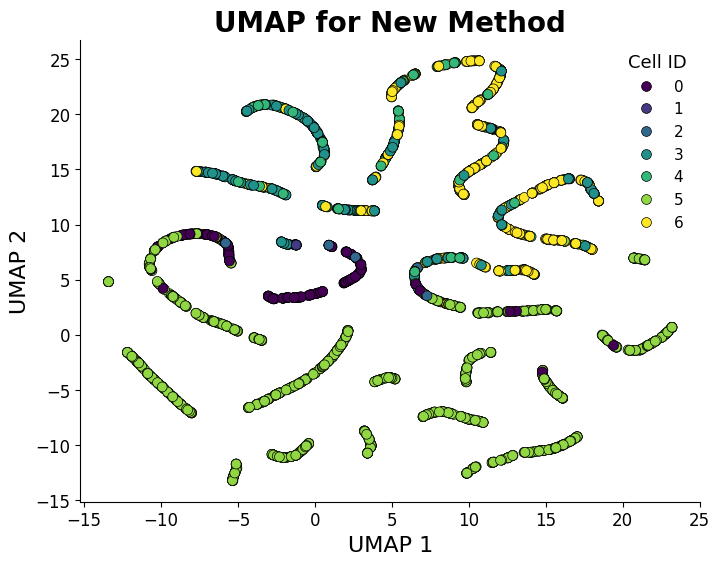

In [65]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the select_cell_id is a NumPy array if it's a PyTorch tensor

# UMAP on PCA results for data1_mts
umap1 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
umap_result1 = umap1.fit_transform(pca_result1)

# Plotting UMAP results with publication quality settings
plt.figure(figsize=(8, 6))  # Slightly adjust the figure size for better readability
sns.scatterplot(x=umap_result1[:,0], y=umap_result1[:,1], hue=select_cell_id_np, palette='viridis', s=50, edgecolor='black', linewidth=0.5)

# Enhance title, labels, and layout
plt.title('UMAP for New Method', fontsize=20, fontweight='bold')
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Removing the spines for a cleaner look
sns.despine()

# Adjust the legend for clarity
plt.legend(title='Cell ID', title_fontsize='13', fontsize='11', loc='best', frameon=False)

# Save figure in high-resolution for publication (e.g., 300 dpi)
# plt.savefig('./fig/umap_new_method_nature.png', dpi=300, bbox_inches='tight')

plt.show()


In [64]:
for idx, _cell in en
dataset_atac.array_celltype


array(['B', 'Fibroblast', 'Myeloid', 'N_Epithelial', 'P_Epithelial', 'T',
       'T_Epithelial'], dtype=object)

In [61]:
cell_type

[0,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 5,
 3,
 5,
 0,
 6,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 3,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 3,
 5,
 1,
 0,
 5,
 0,
 0,
 0,
 1,
 5,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [60]:
cell_type_code

['OMIX005759-28#P09_C_A_58_58',
 'OMIX005759-28#P09_C_C_74_266',
 'OMIX005759-28#P09_C_A_80_80',
 'OMIX005759-28#P09_C_B_90_186',
 'OMIX005759-28#P09_C_D_78_366',
 'OMIX005759-28#P09_C_D_73_361',
 'OMIX005759-28#P09_C_D_3_291',
 'OMIX005759-28#P09_T_B_69_165',
 'OMIX005759-28#P09_T_A1_52_52',
 'OMIX005759-28#P09_C_D_65_353',
 'OMIX005759-28#P09_C_D_18_306',
 'OMIX005759-28#P09_T_D_19_307',
 'OMIX005759-28#P09_T_A1_28_28',
 'OMIX005759-28#P09_T_C1_23_215',
 'OMIX005759-28#P09_C_A_66_66',
 'OMIX005759-28#P09_T_A1_69_69',
 'OMIX005759-28#P09_T_A1_78_78',
 'OMIX005759-28#P09_T_A_42_42',
 'OMIX005759-28#P09_T_B_53_149',
 'OMIX005759-28#P09_C_A_64_64',
 'OMIX005759-28#P09_C_C_94_286',
 'OMIX005759-28#P09_T_A_67_67',
 'OMIX005759-28#P09_C_C_79_271',
 'OMIX005759-28#P09_T_A1_57_57',
 'OMIX005759-28#P09_T_A1_3_3',
 'OMIX005759-28#P09_T_C_85_277',
 'OMIX005759-28#P09_T_C1_45_237',
 'OMIX005759-28#P09_C_C_37_229',
 'OMIX005759-28#P09_C_C_55_247',
 'OMIX005759-28#P09_T_A_22_22',
 'OMIX005759-28#P0

In [31]:
cell_type_code

['OMIX005759-28#P09_C_A_58_58',
 'OMIX005759-28#P09_C_C_74_266',
 'OMIX005759-28#P09_C_A_80_80',
 'OMIX005759-28#P09_C_B_90_186',
 'OMIX005759-28#P09_C_D_78_366',
 'OMIX005759-28#P09_C_D_73_361',
 'OMIX005759-28#P09_C_D_3_291',
 'OMIX005759-28#P09_T_B_69_165',
 'OMIX005759-28#P09_T_A1_52_52',
 'OMIX005759-28#P09_C_D_65_353',
 'OMIX005759-28#P09_C_D_18_306',
 'OMIX005759-28#P09_T_D_19_307',
 'OMIX005759-28#P09_T_A1_28_28',
 'OMIX005759-28#P09_T_C1_23_215',
 'OMIX005759-28#P09_C_A_66_66',
 'OMIX005759-28#P09_T_A1_69_69',
 'OMIX005759-28#P09_T_A1_78_78',
 'OMIX005759-28#P09_T_A_42_42',
 'OMIX005759-28#P09_T_B_53_149',
 'OMIX005759-28#P09_C_A_64_64',
 'OMIX005759-28#P09_C_C_94_286',
 'OMIX005759-28#P09_T_A_67_67',
 'OMIX005759-28#P09_C_C_79_271',
 'OMIX005759-28#P09_T_A1_57_57',
 'OMIX005759-28#P09_T_A1_3_3',
 'OMIX005759-28#P09_T_C_85_277',
 'OMIX005759-28#P09_T_C1_45_237',
 'OMIX005759-28#P09_C_C_37_229',
 'OMIX005759-28#P09_C_C_55_247',
 'OMIX005759-28#P09_T_A_22_22',
 'OMIX005759-28#P0

In [29]:
cell_link_mt = cell_link_mt.to('cpu')

In [ ]:
cell_link_mt

In [26]:
cell_type_code = (cell_type_code)

ValueError: too many dimensions 'str'

In [16]:
df_mat_RIS.to_csv('../output/run_scregat_placenta_add_EVT_out/lamda2_add_hic_df_mat_RIS.csv', sep=' ',index=False,header=False)
with open("../output/run_scregat_placenta_add_EVT_out/lamda2_add_hic_df_mat_RIS_index.txt", "w") as file:
    for item in df_mat_RIS.index.to_list():
        file.write(item + "\n")
with open("../output/run_scregat_placenta_add_EVT_out/lamda2_add_hic_df_mat_RIS_columns.txt", "w") as file:
    for item in df_mat_RIS.columns:
        file.write(str(item) + "\n")

[0,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 5,
 3,
 5,
 0,
 6,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 3,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 3,
 5,
 1,
 0,
 5,
 0,
 0,
 0,
 1,
 5,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [12]:
sample.cell

['OMIX005759-18#P25_C_D_21_309']

In [11]:
cell_type

[0,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 5,
 3,
 5,
 0,
 6,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 3,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 3,
 5,
 1,
 0,
 5,
 0,
 0,
 0,
 1,
 5,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
